In [1]:
import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from IPython import embed
import random

Using MPI version 4.0, 1 processes


In [2]:
mp.Verbosity(2)

resolution = 20

n_fusedSilica = 1.44
n_PDMS = 1.4
n_amorphousSi = 3.48

a = 0.680   # lattice period 

pml_thickness = 0.780
height_pillar = 1.020
width_PDMS = 1.560
width_fusedSilica = 0.780

cell_x = a * 3
cell_y = a * 3
cell_z = round(2*pml_thickness + width_PDMS + height_pillar +  width_fusedSilica, 3)

center_PDMS = round(0.5*(height_pillar + width_PDMS + pml_thickness) 
                    + (pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_fusedSilica = round(0.5*(pml_thickness + width_fusedSilica) - 0.5*cell_z, 3)
center_pillar = round(pml_thickness + width_fusedSilica + 0.5*height_pillar
                    - 0.5*cell_z, 3) 

z_fusedSilica = pml_thickness + width_fusedSilica
z_PDMS = height_pillar + width_PDMS + pml_thickness

In [3]:
geometry = [mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_fusedSilica), 
                    center=mp.Vector3(0,0,center_fusedSilica),
                    material=mp.Medium(index=n_fusedSilica)),
            mp.Block(size=mp.Vector3(mp.inf,mp.inf,z_PDMS),
                    center=mp.Vector3(0,0,center_PDMS),
                    material=mp.Medium(index=n_PDMS))]

k_point = mp.Vector3(0,0,0)
#k_point = mp.Vector3(np.radians(35), 0, 0)  # k vector defines normal to the plane of propagation

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num = 6 # this is the number of pillars we will build
data = np.zeros((3,num))
dfts = []

## set up and build source ##
############################

center_source = round(pml_thickness + width_fusedSilica*0.2 - 0.5*cell_z, 3) 
source_cmpt = mp.Ey

fcen = freq
fwidth=0.2*freq

sources = [mp.Source(mp.GaussianSource(fcen, fwidth=fwidth), component = source_cmpt,
                            center=mp.Vector3(0,0,center_source),
                            size=mp.Vector3(cell_x,cell_y,0))]

def run_sim():
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, source_cmpt, mp.Vector3(0, 0, cell_z), 1e-2))

In [4]:
cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    #symmetries=symmetries,
                    resolution=resolution)
nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness - 0.3*width_PDMS, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

# fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
#             size=mp.Vector3(a, a, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)
where=mp.Volume(center=mp.Vector3(0, 0, fr_center), size=mp.Vector3(cell_x, cell_y, 0))
dft_object = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez], freq, df, nfreq, where=where)
run_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000104189 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
time for set_epsilon = 0.941013 s
-----------
on time step 1388 (time=34.7), 0.00288331 s/step
field decay(t = 50.025000000000006): 0.12053885221037682 / 0.12053885221037682 = 1.0
on time step 3061 (time=76.525), 0.00239202 s/step
field decay(t = 100.05000000000001): 0.028505959764893892 / 0.12053885221037682 = 0.23648773189861105
on time step 4704 (time=117.6), 0.00243518 s/step
field decay(t = 150.07500000000002): 6.901501745057479e-09 / 0.12053885221037682 = 5.7255412827

In [5]:
initial_flux = mp.get_fluxes(flux_object)[0]     # initial flux
initial_dft = [sim.get_dft_array(dft_object, mp.Ex, 0),
               sim.get_dft_array(dft_object, mp.Ey, 0),
               sim.get_dft_array(dft_object, mp.Ez, 0)]
sim.reset_meep()
print(initial_flux)
len(initial_dft)

10.5126710512241


3

In [6]:
print(len(initial_dft[0]))
print(len(initial_dft[1]))
print(len(initial_dft[2]))
print(initial_dft[0].shape)

42
42
42
(42, 42)


In [7]:
x_list = [-a, 0, a, -a, 0, a, -a, 0, a]
y_list = [a, a, a, 0, 0, 0, -a, -a, -a] 
radii_list = np.random.uniform(0.075, 0.250, 9)

for i, neighbor in enumerate(radii_list):
    radius = neighbor
    x_dim = x_list[i]
    y_dim = y_list[i]
    geometry.append(mp.Cylinder(radius=radii_list[i],
                                height=height_pillar,
                                axis=mp.Vector3(0,0,1),
                                center=mp.Vector3(x_list[i], y_list[i], center_pillar),
                                material=mp.Medium(index=n_amorphousSi)))

In [8]:
pbar = tqdm(total=num,leave=False)
central_index = None
for i,radius in enumerate(np.linspace(0.075,0.25,num=num)):
    for j, pillar in enumerate(geometry):
        if pillar.center == mp.Vector3(0,0,center_pillar):
            central_index = j
            print(f"central_index = {j}")
    if central_index is not None:
        geometry.pop(central_index)
    print(f"central pillar: {radius}")
    geometry.append(mp.Cylinder(radius=radius,
                        height=height_pillar,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_pillar),
                        material=mp.Medium(index=n_amorphousSi)))

    print(f"at iteration {i} the central pillar is at {geometry[central_index].center} with {geometry[central_index].radius}")
    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        #symmetries=symmetries,
                        resolution=resolution)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)  
    dft_object = sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez], freq, df, nfreq, where=where)
    
    run_sim()
    
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 
    
    data[0,i] = radius
    data[1,i] = flux
    data[2,i] = phase
    # if(radius!=0.25):
    #     sim.reset_meep()
    #     print(f"i= {i},radius={radius}")
    #     geometry.pop(5)
    dfts.append([sim.get_dft_array(dft_object, mp.Ex, 0), sim.get_dft_array(dft_object, mp.Ey, 0), sim.get_dft_array(dft_object, mp.Ez, 0)])

    pbar.update(1)
pbar.close()

  0%|                                       | 0/6 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 6
central pillar: 0.075
at iteration 0 the central pillar is at Vector3<0.68, 0.0, -0.39> with 0.13487928659755596
-----------
Initializing structure...
time for choose_chunkdivision = 9.48906e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.227475, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.159218, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     

field decay(t = 250.125): 1.9708694899569095e-05 / 0.003602116662046023 = 0.005471420486524288
run 0 finished at t = 250.125 (10005 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 17%|█████▏                         | 1/6 [00:28<02:21, 28.38s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.10999999999999999
at iteration 1 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.10999999999999999
-----------
Initializing structure...
time for choose_chunkdivision = 3.71933e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.227475, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.159218, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,

field decay(t = 200.10000000000002): 8.534781411261003e-05 / 0.022732877948790767 = 0.003754377879689006
run 0 finished at t = 200.10000000000002 (8004 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 33%|██████████▎                    | 2/6 [00:50<01:38, 24.75s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.145
at iteration 2 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.145
-----------
Initializing structure...
time for choose_chunkdivision = 4.1008e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.227475, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.159218, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, cente

field decay(t = 150.07500000000002): 0.0011926424110886066 / 0.261472876455736 = 0.004561247144464353
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 50%|███████████████▌               | 3/6 [01:07<01:03, 21.11s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.18
at iteration 3 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.18
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.227475, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.159218, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center

field decay(t = 150.07500000000002): 0.004236739923446539 / 0.5312160245478269 = 0.007975549922562799
run 0 finished at t = 150.07500000000002 (6003 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 67%|████████████████████▋          | 4/6 [01:24<00:39, 19.51s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.21499999999999997
at iteration 4 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.21499999999999997
-----------
Initializing structure...
time for choose_chunkdivision = 0.000105143 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.227475, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.159218, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,

field decay(t = 200.10000000000002): 0.001202662989057398 / 0.34245952992442025 = 0.0035118397473792654
run 0 finished at t = 200.10000000000002 (8004 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


 83%|█████████████████████████▊     | 5/6 [01:48<00:21, 21.04s/it]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


central_index = 10
central pillar: 0.25
at iteration 5 the central pillar is at Vector3<0.0, 0.0, -0.39> with 0.25
-----------
Initializing structure...
time for choose_chunkdivision = 4.19617e-05 s
Working in 3D dimensions.
Computational cell is 2.05 x 2.05 x 4.9 with resolution 20
     block, center = (0,0,-1.68)
          size (1e+20,1e+20,1.56)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.0736,2.0736,2.0736)
     block, center = (0,0,0.78)
          size (1e+20,1e+20,3.36)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.96,1.96,1.96)
     cylinder, center = (-0.68,0.68,-0.39)
          radius 0.227475, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center = (0,0.68,-0.39)
          radius 0.159218, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.1104,12.1104,12.1104)
     cylinder, center

field decay(t = 200.10000000000002): 0.0014382700502670559 / 0.3868568936166678 = 0.00371783487382345
run 0 finished at t = 200.10000000000002 (8004 timesteps)
MPB solved for frequency_1(0,0,0.903226) = 0.645161 after 17 iters
Dominant planewave for band 1: (0.000000,0.000000,0.903226)


In [9]:
def get_intensity(Ex, Ey, Ez):
    print(Ex.shape)
    E_0 = np.sqrt((abs(Ex)**2 + abs(Ey)**2 + abs(Ez)**2))
    I = 0.5 * E_0**2
    return(np.mean(I))

initial_I = get_intensity(initial_dft[0], initial_dft[1], initial_dft[2])
print(initial_I)

(42, 42)
0.8800985069702292


In [10]:
print(initial_dft[0].shape)

(42, 42)


In [11]:
I_list = []
for dft in dfts:
    print(dft[0].shape, dft[1].shape, dft[2].shape)
    I = get_intensity(dft[0], dft[1], dft[2])
    I_list.append(I / initial_I)

(42, 42) (42, 42) (42, 42)
(42, 42)
(42, 42) (42, 42) (42, 42)
(42, 42)
(42, 42) (42, 42) (42, 42)
(42, 42)
(42, 42) (42, 42) (42, 42)
(42, 42)
(42, 42) (42, 42) (42, 42)
(42, 42)
(42, 42) (42, 42) (42, 42)
(42, 42)


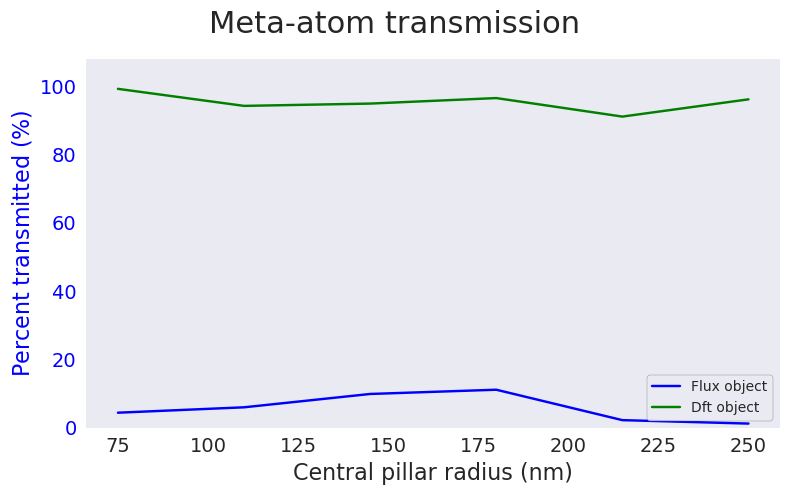

In [12]:
radii = data[0,:]
flux_list = data[1,0:] / initial_flux
phase_list = data[2,0:]

#plt.style.use('seaborn')

results = {"radii": radii, "flux": flux_list, "phase": phase_list}
# this section plots radius vs. phase and transmission
plt.style.use('seaborn-v0_8')

tickfontsize=14
labelfontsize=16
titlefontsize=22
padding = 0.08
plt.close("all")
fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom transmission",fontsize=titlefontsize)

ax.set_xlabel("Central pillar radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])
ax.set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
ax.set_ylim([0,1+padding])
ax.set_ylabel(r'Percent transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.plot(radii,flux_list,'b',label='Flux object')
ax.plot(radii,I_list,'green',label='Dft object')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)

ax.legend(frameon=True, edgecolor='dimgrey')
# twin1 = ax.twinx()

# twin1.set_ylim([-np.pi,np.pi])
# twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
# twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
# twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
# twin1.plot(radii,phase_list,'r',label='Phase')
# twin1.tick_params(axis='y', labelcolor = 'red')

plt.grid(False)
plt.tight_layout()